# Final Project Program Rutvik Rathva

Presentation link: https://drive.google.com/drive/folders/1XIqPDsHgmZ7rKFztgqrkVmQXaqyG_OYX?usp=sharing

Reference: https://www.tensorflow.org/tutorials/generative/dcgan

### Importing libraries

In [ ]:
import tensorflow as tf # Importing required libraries

### We require gdown for loading the dataset into our notebook session; numpy, matplotlib, cv2, PIL, IPython for manipulating and displaying images; tensorflow for building and training the model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import cv2
import gdown
import os

from IPython import display

### Loading, plotting and preparing the defect images(may take up to 40 seconds to load)

In [ ]:
url = "https://drive.google.com/file/d/1xpW9Wfwod0__fkoocs-wcqMxAmdN3sje/view?usp=sharing"
output = "images.zip"
gdown.download(url, output=output, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1xpW9Wfwod0__fkoocs-wcqMxAmdN3sje
To: /content/images.zip
100%|██████████| 2.61M/2.61M [00:00<00:00, 118MB/s]


'images.zip'

In [ ]:
!unzip images.zip

Archive:  images.zip
  inflating: ME228_data_4000/crack1.jpeg  
  inflating: ME228_data_4000/crack10.jpeg  
  inflating: ME228_data_4000/crack100.jpeg  
  inflating: ME228_data_4000/crack1000.jpeg  
  inflating: ME228_data_4000/crack1001.jpeg  
  inflating: ME228_data_4000/crack1002.jpeg  
  inflating: ME228_data_4000/crack1003.jpeg  
  inflating: ME228_data_4000/crack1004.jpeg  
  inflating: ME228_data_4000/crack1005.jpeg  
  inflating: ME228_data_4000/crack1006.jpeg  
  inflating: ME228_data_4000/crack1007.jpeg  
  inflating: ME228_data_4000/crack1008.jpeg  
  inflating: ME228_data_4000/crack1009.jpeg  
  inflating: ME228_data_4000/crack101.jpeg  
  inflating: ME228_data_4000/crack1010.jpeg  
  inflating: ME228_data_4000/crack1011.jpeg  
  inflating: ME228_data_4000/crack1012.jpeg  
  inflating: ME228_data_4000/crack1013.jpeg  
  inflating: ME228_data_4000/crack1014.jpeg  
  inflating: ME228_data_4000/crack1015.jpeg  
  inflating: ME228_data_4000/crack1016.jpeg  
  inflating: ME228_d

### We are using 2000 images of cracks in concrete bridges from the Kaggle dataset. The size of the images is 16*16. We also reshape the dataset array into a form which tensorflow accepts.
Reference: https://www.kaggle.com/datasets/yidazhang07/bridge-cracks-image

In [ ]:
train_images = [] # Loading the data
for i in range(2000):
  img = cv2.imread('/content/ME228_data_4000/crack' + str(i+1) + '.jpeg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  train_images.append(img)
train_images = np.array(train_images)
train_images = train_images.reshape(train_images.shape[0], 16, 16, 1).astype('float32')

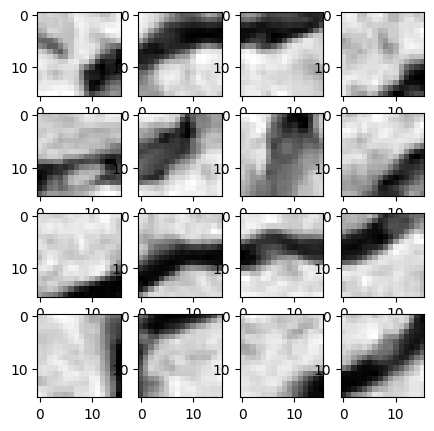

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(5, 5)) # Plotting original images
axes[0, 0].imshow(train_images[0], cmap='gray')
axes[0, 1].imshow(train_images[1], cmap='gray')
axes[0, 2].imshow(train_images[2], cmap='gray')
axes[0, 3].imshow(train_images[3], cmap='gray')
axes[1, 0].imshow(train_images[4], cmap='gray')
axes[1, 1].imshow(train_images[5], cmap='gray')
axes[1, 2].imshow(train_images[6], cmap='gray')
axes[1, 3].imshow(train_images[7], cmap='gray')
axes[2, 0].imshow(train_images[8], cmap='gray')
axes[2, 1].imshow(train_images[9], cmap='gray')
axes[2, 2].imshow(train_images[10], cmap='gray')
axes[2, 3].imshow(train_images[11], cmap='gray')
axes[3, 0].imshow(train_images[12], cmap='gray')
axes[3, 1].imshow(train_images[13], cmap='gray')
axes[3, 2].imshow(train_images[14], cmap='gray')
axes[3, 3].imshow(train_images[15], cmap='gray')

In [ ]:
train_images = (train_images - 127.5) / 127.5 # Manipulating the data to lie between -1 and 1
train_images.shape

(2000, 16, 16, 1)

### The following code shuffles the first 'BUFFER_SIZE' images of the dataset, and divides them into batches of size 'BATCH_SIZE'. We want to shuffle the whole dataset, so 'BUFFER_SIZE' = 2000

In [ ]:
BUFFER_SIZE = 2000
BATCH_SIZE = 256

### The images are processed one batch at a time.

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator model: the generator takes input of a 1D 100 element tensor, and returns a 16*16 image. There is one dense layer, 3 conv2Dtranspose layers, and one output layer. All the layers except the output layer have Leaky ReLU as the activation function.The output layer uses tanh as the activation function.

In [ ]:
def make_generator_model(): # Defining the layers of the generator
  model = tf.keras.Sequential()
  model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((4, 4, 256)))
  assert model.output_shape == (None, 4, 4, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 4, 4, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 16, 16, 1)

  return model

### We run the generator with random noise to see if it successfully generates an image.

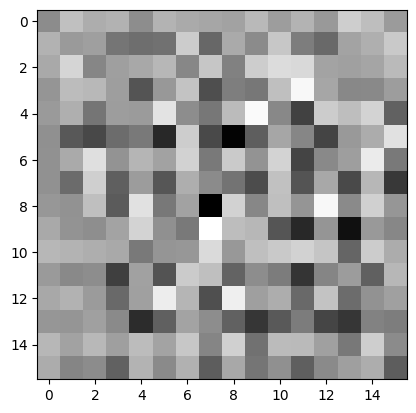

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)  # Checking that the generator works

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator model: the discriminator takes a 16*16 image as input and gives a single element tensor as output. It is a simple CNN-based classifier. It consists of 2 convolutional layers and a dense layer as the output layer.

In [ ]:
def make_discriminator_model(): # Defining the layers of the discriminator
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[16, 16, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

### We run the discriminator on the above-generated image to see if the discriminator works.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image) # Checking that the discriminator works
print (decision)

tf.Tensor([[-0.00209671]], shape=(1, 1), dtype=float32)


### Defining optimizers: we use binary cross entropy loss and Adam's optimizer with learning rate = $10^{-4}$

### Loss: $\frac{1}{N}$ $\sum_{i=1}^{N}$ ($y_i$)*log($p_i$) + ($1-y_i$)*log($p_i$)

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### The discriminator loss function returns the sum of real loss and fake loss. Real loss is the loss for the discriminator prediction for the real image, and fake loss is the loss for the discriminator prediction of the fake image given by the generator.

In [ ]:
def discriminator_loss(real_output, fake_output): # Defining discriminator loss
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

### The generated loss is calculated based on the discriminator's response to the generated image.

In [ ]:
def generator_loss(fake_output):  # Defining generator loss
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)  # We use Adam optimizer with learning rate 10^(-4) for both generator and discriminator
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoints have been setup to save progress during training.

In [ ]:
checkpoint_dir = './training_checkpoints' # Setting up checkpoints to save during training
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 1000 # No. of iterations
noise_dim = 100  # We define a random seed to input to the generator to generate images from. It is an array of dimensions (no. of images*100)
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Defining the train function

### In one training step, the generator generates images equal to whatever batch size has been set. The discriminator gives real and fake outputs based on real and generated images. Using these outputs, generator and discriminator losses are calculated. These losses then give us the gradients which are fed to the optimizer to update the weights.

In [ ]:
# The @tf.function annotation causes the function to be "compiled".
@tf.function
def train_step(images): # Training step
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### After each training step, the output of the cell is updated with the latest generated images, producing a gif of image generation as the model trains.

In [ ]:
def train(dataset, epochs): # Training function
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### This function generates, saves, and plots images.

In [ ]:
def generate_and_save_images(model, epoch, test_input): # Function to generate images for every epoch
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5, 5))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Training the model

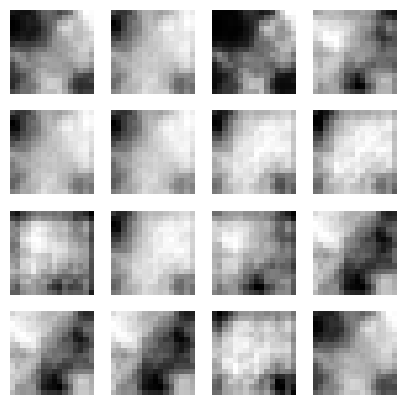

In [ ]:
train(train_dataset, EPOCHS)  # Training the model

In [ ]:
from PIL import Image

### Generating and saving images after training is done.

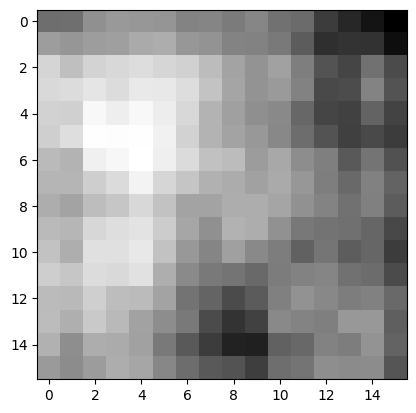

In [ ]:
new_seed = tf.random.normal([2000, noise_dim])  # Getting random seed to generate images

generated_list = np.array(generator(new_seed, training=False))  # Generating 2000 images
generated_list = np.reshape(generated_list, (-1, 16, 16))
generated_list = generated_list*127.5 + 127.5

for i in range(2000): # Saving the generated images
  plt.imshow(generated_list[i], cmap='gray')
  img = Image.fromarray(np.uint8(generated_list[i]), 'L')
  img.save('/content/images_1/image' + str(i+1) + '.png')

In [ ]:
!zip -r /content/file_3.zip /content/images_1  # Zipping the image folder to download it

  adding: content/images_1/ (stored 0%)
  adding: content/images_1/image528.png (stored 0%)
  adding: content/images_1/image1681.png (stored 0%)
  adding: content/images_1/image638.png (stored 0%)
  adding: content/images_1/image1143.png (stored 0%)
  adding: content/images_1/image1525.png (stored 0%)
  adding: content/images_1/image1676.png (stored 0%)
  adding: content/images_1/image1522.png (stored 0%)
  adding: content/images_1/image843.png (stored 0%)
  adding: content/images_1/image634.png (stored 0%)
  adding: content/images_1/image1830.png (stored 0%)
  adding: content/images_1/image456.png (stored 0%)
  adding: content/images_1/image153.png (stored 0%)
  adding: content/images_1/image1492.png (stored 0%)
  adding: content/images_1/image1559.png (stored 0%)
  adding: content/images_1/image869.png (stored 0%)
  adding: content/images_1/image59.png (stored 0%)
  adding: content/images_1/image1435.png (stored 0%)
  adding: content/images_1/image1168.png (stored 0%)
  adding: conte